In [26]:
import os, os.path as osp
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

from src.common.files import get_raw_paths
from src.visualization.render_mp4 import unpickle_data

import furniture_bench.utils.transform as T

In [33]:
# data_dir_raw_base = Path(os.environ["DATA_DIR_RAW"])
data_dir_raw_base = Path("/home/anthony/repos/research/robust-rearrangement/assembly-data")

run_name = "ol-state-dr-med-1/9zjnzg4r"
# run_name = "residual-ppo-dr-1/7mv6o4i9"
# run_name = "residual-ppo-dr-med-1/h7dg0og4"

# run_name = "ol-state-dr-1/r9wm1uo6"
# run_name = "residual-ppo-dr-1/fj7ggmg7"

data_dir_raw_new = data_dir_raw_base / "coverage" / run_name 
os.environ["DATA_DIR_RAW"] = str(data_dir_raw_new)

fail_pkl_paths = get_raw_paths(
    controller="diffik",
    domain="sim",
    randomness="med",
    task=["one_leg"],
    demo_source=["rollout"],
    demo_outcome=["failure"],
    suffix="coverage" if "9zjnzg4r" not in run_name else None
)

success_pkl_paths = get_raw_paths(
    controller="diffik",
    domain="sim",
    randomness="med",
    task=["one_leg"],
    demo_source=["rollout"],
    demo_outcome=["success"],
    suffix="coverage" if "9zjnzg4r" not in run_name else None
)

n_fail, n_success = len(fail_pkl_paths), len(success_pkl_paths)
total_runs = n_fail + n_success
print(f'Num fail: {n_fail}, Num success: {n_success}, Total: {total_runs}')

Found the following paths:
    /home/anthony/repos/research/robust-rearrangement/assembly-data/coverage/ol-state-dr-med-1/9zjnzg4r/raw/diffik/sim/one_leg/rollout/med/**/failure/*.pkl*
Found the following paths:
    /home/anthony/repos/research/robust-rearrangement/assembly-data/coverage/ol-state-dr-med-1/9zjnzg4r/raw/diffik/sim/one_leg/rollout/med/**/success/*.pkl*
Num fail: 4075, Num success: 1150, Total: 5225


In [28]:
# constants
april_to_sim_mat = np.array(
    [
        [6.1232343e-17, 1.0000000e00, 1.2246469e-16, 1.4999807e-03],
        [1.0000000e00, -6.1232343e-17, -7.4987988e-33, 0.0000000e00],
        [0.0000000e00, 1.2246469e-16, -1.0000000e00, 4.1500002e-01],
        [0.0000000e00, 0.0000000e00, 0.0000000e00, 1.0000000e00],
    ]
)

In [29]:
# let's get the (x, y, theta) start poses for the leg

leg_3d_poses = {}
leg_3d_poses["success"] = []
leg_3d_poses["failure"] = []

leg_rot_mats = {}
leg_rot_mats["success"] = []
leg_rot_mats["failure"] = []

sf_pkl_paths = dict(success=success_pkl_paths, failure=fail_pkl_paths)


def get_part_inds(part_idx: int):
    return 7 * part_idx, 7 * part_idx + 7


def get_part_pose(pkl_path: str, part_name: str="leg"):
    try:
        data = unpickle_data(pkl_path)
    except EOFError as e:
        print(f'Error: {e}')
        print(f'Skipping {pkl_path}')
        raise
    # print(data.keys())
    
    init_obs = data["observations"][0]
    # print(init_obs.keys())

    part_poses = init_obs["parts_poses"]

    if part_name == "leg":
        si, ei = get_part_inds(4)
    elif part_name == "obstacle":
        si, ei = get_part_inds(5)
    elif part_name == "table_top":
        si, ei = get_part_inds(0)
    
    # print(f'Start: {si}, End: {ei}')
    
    return part_poses[si:ei]


for sf in ["success", "failure"]:
    pkl_paths = sf_pkl_paths[sf]
    leg_pose_list = leg_3d_poses[sf]
    rot_mat_list = leg_rot_mats[sf]

    for pth in pkl_paths:
        try:
            leg_pose_april = get_part_pose(pth, part_name="leg")
        except EOFError as e:
            continue
        leg_pose_mat = april_to_sim_mat @ (T.to_homogeneous(leg_pose_april[:3], T.quat2mat(leg_pose_april[3:])))
        leg_xy = leg_pose_mat[:2, -1]
        leg_theta = np.rad2deg(R.from_matrix(leg_pose_mat[:-1, :-1]).as_euler('XYZ')[1])
        leg_pose_3d = np.array([leg_xy[0] + 0.3, leg_xy[1], leg_theta]) 
        # print(f"Leg pose: {leg_pose_3d}")

        leg_pose_list.append(leg_pose_3d)
        rot_mat_list.append(leg_pose_mat[:-1, :-1])

        # break
    
    leg_3d_poses[sf] = np.asarray(leg_pose_list)
    # leg_rot_mats[sf] = np.rad2deg(np.asarray(rot_mat_list))

print(f'Length: {len(leg_3d_poses["success"])}, {len(leg_3d_poses["failure"])}')

Length: 1178, 614


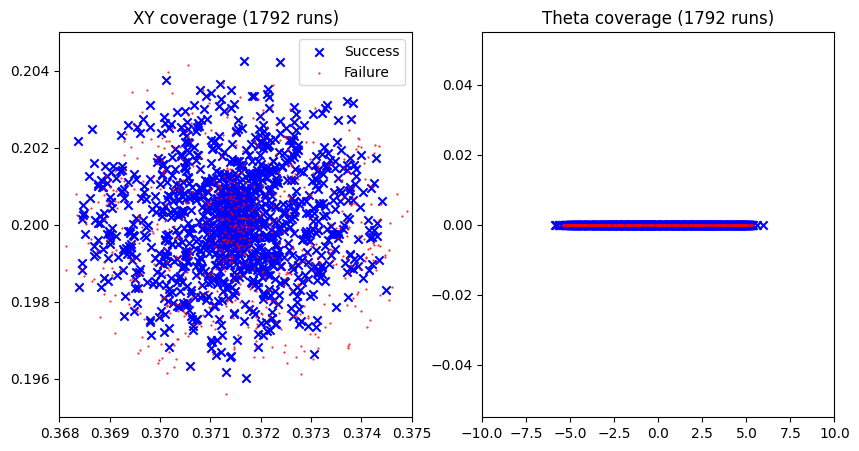

In [30]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax[0].scatter(leg_3d_poses["success"][:, 0], leg_3d_poses["success"][:, 1], color="blue", marker="x")
ax[0].scatter(leg_3d_poses["failure"][:, 0], leg_3d_poses["failure"][:, 1], color="red", marker=".", s=1)
# plt.xlim([0.2, 0.5])
# plt.ylim([-0.3, 0.3])
ax[0].legend(["Success", "Failure"])
ax[0].set_title(f"XY coverage ({total_runs} runs)")
ax[0].set_xlim([0.368, 0.375]) 
ax[0].set_ylim([0.195, 0.205])

ax[1].scatter(leg_3d_poses["success"][:, 2], np.zeros(leg_3d_poses["success"].shape[0]), color="blue", marker="x")
ax[1].scatter(leg_3d_poses["failure"][:, 2], np.zeros(leg_3d_poses["failure"].shape[0]), color="red", marker=".", s=1)
# ax[1].legend(["Success", "Failure"])
ax[1].set_title(f"Theta coverage ({total_runs} runs)")
ax[1].set_xlim([-10, 10])

plt.show()

In [31]:
import numpy as np
import plotly.graph_objects as go

# Example dataset of 3D vectors (x, y, theta)
all_vectors = np.concatenate([leg_3d_poses["success"], leg_3d_poses["failure"]], axis=0)
vectors, save_fname = leg_3d_poses["success"], f"{run_name.replace('/', '--')}_success_coverage.html"
# vectors, save_fname = all_vectors, f"{run_name.replace('/', '--')}_all_coverage.html"

# Define the number of bins (voxels) along each axis
# num_bins = [10, 10, 10]
num_bins = [16, 16, 16]

# Find the min and max values for each component
mins = np.min(all_vectors, axis=0)
maxs = np.max(all_vectors, axis=0)

# ax[0].set_xlim([0.368, 0.375]) 
# ax[0].set_ylim([0.195, 0.205])
mins[0] = 0.368; mins[1] = 0.195; mins[2] = -10.0
maxs[0] = 0.375; maxs[1] = 0.205; maxs[2] = 10.0

# Compute the bin size for each component
bin_sizes = (maxs - mins) / num_bins

# Discretize the vectors into voxel grid cells
voxel_indices = np.floor((vectors - mins) / bin_sizes).astype(int)

# Ensure indices are within bounds
voxel_indices = np.clip(voxel_indices, 0, np.array(num_bins) - 1)

# Create a 3D grid using np.meshgrid
x_bins = np.linspace(mins[0], maxs[0], num_bins[0] + 1)
y_bins = np.linspace(mins[1], maxs[1], num_bins[1] + 1)
theta_bins = np.linspace(mins[2], maxs[2], num_bins[2] + 1)

# Create a 3D histogram to count the number of vectors in each voxel
hist, edges = np.histogramdd(vectors, bins=[x_bins, y_bins, theta_bins])
all_hist, all_edges = np.histogramdd(all_vectors, bins=[x_bins, y_bins, theta_bins])

# Get the coordinates of the centers of the bins
x_centers = (edges[0][:-1] + edges[0][1:]) / 2
y_centers = (edges[1][:-1] + edges[1][1:]) / 2
theta_centers = (edges[2][:-1] + edges[2][1:]) / 2

# Create a meshgrid for plotting
x_mesh, y_mesh, theta_mesh = np.meshgrid(x_centers, y_centers, theta_centers, indexing='ij')

# Flatten the meshgrid and histogram for plotting
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
theta_flat = theta_mesh.flatten()
hist_flat = hist.flatten()

# Determine marker properties based on occupancy
marker_size = np.where(hist_flat > 0, 5, 2.05)
# marker_opacity = np.where(hist_flat > 0, 0.8, 0.1)
marker_opacity = 0.8
# marker_color = np.where(hist_flat > 0, hist_flat, 'lightgray')
# marker_color = np.where(hist_flat > 0, hist_flat, 0)  # Set color to zero for unoccupied
marker_color = np.where(hist_flat > 0, 0.5, 0.0)  # Set color to zero for unoccupied


# Compute the number of occupied voxels
occupied_voxels = np.count_nonzero(hist)
all_occupied_voxels = np.count_nonzero(all_hist)

# Compute the total number of voxels
total_voxels = np.prod(num_bins)

# Calculate coverage metrics
succ_overage_ratio = (occupied_voxels / total_voxels) * 100
all_coverage_ratio = (all_occupied_voxels / total_voxels) * 100
# coverage = (all_coverage_ratio - coverage_ratio) * 100 / all_coverage_ratio
coverage = occupied_voxels * 100.0 / all_occupied_voxels

# Create a scatter plot with Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=x_flat,
    y=y_flat,
    z=theta_flat,
    mode='markers',
    marker=dict(
        size=marker_size,
        color=marker_color,
        # colorscale='Viridis',
        # colorscale='rdpu',
        colorscale='Turbo',
        opacity=marker_opacity,
        # colorbar=dict(title='Number of Points', thickness=15)
    )
)])

# Set labels for the axes
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Theta'
    ),
    title=f'Run {run_name} - Coverage ratio: {coverage:.3f}%, Success: {succ_overage_ratio:.2f}%',
    width=800,  # Set the figure width
    height=600  # Set the figure height
)

# # Create a scatter plot with Plotly
# fig = go.Figure(data=[go.Scatter3d(
#     x=x_flat,
#     y=y_flat,
#     z=theta_flat,
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=hist_flat,
#         colorscale='Viridis',
#         colorbar=dict(title='Number of Points'),
#         opacity=0.8
#     )
# )])

# Show the plot
# fig.write_html("plots/sample_coverage.html")
fig.write_html(f"plots/{save_fname}")
fig.show()

# Print the metrics
print(f"Coverage Ratio: {coverage:.3f}%, Success coverage: {succ_overage_ratio:.3f}, All coverage: {all_coverage_ratio:.3f}")
print(f"Num success occ: {occupied_voxels}, Num all occ: {all_occupied_voxels}")


Coverage Ratio: 72.796%, Success coverage: 14.111, All coverage: 19.385
Num success occ: 578, Num all occ: 794
